In [17]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scope import ScopeSolver

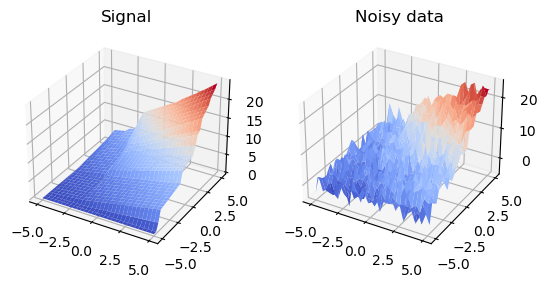

In [18]:
m, n = 30, 30
p = m * n

xx1 = np.linspace(-5, 5, m)
xx2 = np.linspace(-5, 5, n)
X1, X2 = np.meshgrid(xx2, xx2)

theta = np.zeros(p)
pos = np.random.choice(np.arange(p), 8, replace=False)
theta[pos] = 0.1 # np.random.rand(len(pos)) * 5
Theta = (C @ theta).reshape(m, n)

# Theta = -(X1) ** 2 - (X2)**2
# Theta = - 5 * X1 + X2 ** 2 
# Theta = np.zeros((m, n))
# Theta[:, :int(n/3)] = -5 * X1[:, :int(n/3)]
# Theta[:, int(n/3):int(2*n/3)] = -0.5 * X1[:, int(n/3):int(2*n/3)] - 45
# Theta[:, int(2*n/3):] = -5 * X1[:, int(2*n/3):] + 45
# Theta[int(n/2):, :] = 8 * X2[int(n/2):, :] - 195
rng = np.random.default_rng(12345)
noise = rng.standard_normal((m, n)) * 2
Y = Theta + noise

fig = plt.figure(figsize=(10, 5))  


ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, Theta, cmap='coolwarm')
ax1.set_title('Signal')


ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, Y, cmap='coolwarm')
# ax2.plot_surface(X1, X2, Theta, color='red')
ax2.set_title('Noisy data')

plt.show()

In [19]:
def get_c(i, j, s, t):
    if (s > i) or (t > j):
        return 0
    elif (s==0) and (t==0):
        return 1
    elif (s==i) and (t==j):
        return 1
    else:
        return i - s + j - t


# the (k, l) element C(k, l) of the matrix C is gen_matrix(k, l)
def gen_matrix(k, l):
    i = k // n
    j = k % n
    s = l // n
    t = l % n
    return get_c(i, j, s, t)

# C = np.fromfunction(gen_matrix, (p, p))
C = np.zeros((p, p))
for k in range(p):
    for l in range(p):
        C[k, l] = gen_matrix(k, l)

In [20]:
def stf(Y, sparsity):
    m, n = Y.shape
    p = m * n
    y = Y.reshape(-1)

    def custom_objective(params):
        return jnp.mean(jnp.square(y - C @ params))
    
    solver = ScopeSolver(p, sparsity)
    params = solver.solve(custom_objective)
    Theta_hat = (C @ params).reshape(m, n)
    return Theta_hat

In [21]:
sparsity1, sparsity2 = 5, 10
Theta_hat1 = stf(Y, sparsity1)
Theta_hat2 = stf(Y, sparsity2)

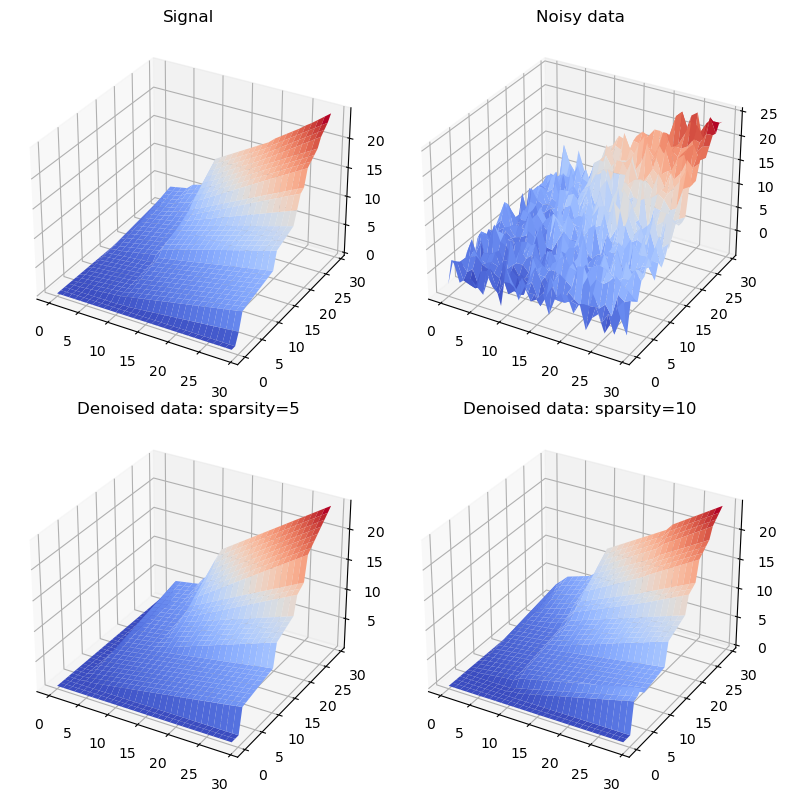

In [22]:
fig = plt.figure(figsize=(8, 8))  

xx1 = np.arange(m)
xx2 = np.arange(n)
X1, X2 = np.meshgrid(xx2, xx2)

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X1, X2, Theta, cmap='coolwarm')
ax1.set_title('Signal')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X1, X2, Y, cmap='coolwarm')
ax2.set_title('Noisy data')

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X1, X2, Theta_hat1, cmap='coolwarm')
ax3.set_title('Denoised data: sparsity={}'.format(sparsity1))

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X1, X2, Theta_hat2, cmap='coolwarm')
ax4.set_title('Denoised data: sparsity={}'.format(sparsity2))

plt.tight_layout()
plt.show()